# Skin Cancer

## 1.1 downloading the dataset

In [ ]:
import kagglehub
import shutil

path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
shutil.copytree(path, './data/skin-cancer')

## read and resize

In [557]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  color_mode='rgb',
  seed=123,
  image_size=(30, 30),
  batch_size=32,
  shuffle=True)

Found 3297 files belonging to 2 classes.


In [558]:
def getImgCountPerClass(dataset):
    class1=0
    all=0
    for images, labels in dataset:
        class1+=(sum(labels[i].numpy() for i in range(images.shape[0])))
        all+=images.shape[0]
    return class1, all-class1

In [559]:
print(getImgCountPerClass(train_ds))

(1497, 1800)


In [560]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def separate_classes(dataset):
    class_0_images, class_0_labels = [], []
    class_1_images, class_1_labels = [], []

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if labels[i].numpy() == 0:
                class_0_images.append(images[i].numpy())
                class_0_labels.append(labels[i].numpy())
            else:
                class_1_images.append(images[i].numpy())
                class_1_labels.append(labels[i].numpy())
    
    return (np.array(class_0_images), np.array(class_0_labels)), (np.array(class_1_images), np.array(class_1_labels))

def augment_class(images, labels, target_count, datagen):
    augmented_images, augmented_labels = [], []
    while len(augmented_images) < target_count:
        random.shuffle(images)
        for i in range(len(images)):
            augmented_image = datagen.random_transform(images[i])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
            if len(augmented_images) >= target_count:
                break
    return np.array(augmented_images), np.array(augmented_labels)

def balance_classes(dataset, datagen, target_count):
    (class_0_images, class_0_labels), (class_1_images, class_1_labels) = separate_classes(dataset)

    if len(class_0_labels) < target_count:
        class_0_images, class_0_labels = augment_class(class_0_images, class_0_labels, target_count, datagen)
    if len(class_1_labels) < target_count:
        class_1_images, class_1_labels = augment_class(class_1_images, class_1_labels, target_count, datagen)

    balanced_images = np.concatenate([class_0_images, class_1_images], axis=0)
    balanced_labels = np.concatenate([class_0_labels, class_1_labels], axis=0)

    indices = np.arange(len(balanced_labels))
    np.random.shuffle(indices)
    balanced_images = balanced_images[indices]
    balanced_labels = balanced_labels[indices]

    return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

train_ds = balance_classes(train_ds, datagen, int(max(getImgCountPerClass(train_ds))*3)).batch(32)

In [561]:
test_ds = train_ds.take(len(train_ds)//10)
val_ds = train_ds.skip(len(train_ds)//10)
val_ds = val_ds.take(len(val_ds)//9)
train_ds = train_ds.skip(len(train_ds)//5)

In [562]:
train_ds = balance_classes(train_ds, datagen, max(getImgCountPerClass(train_ds))).batch(32)
# val_ds = balance_classes(val_ds, datagen, max(getImgCountPerClass(val_ds))).batch(32)
# test_ds = balance_classes(test_ds, datagen, max(getImgCountPerClass(test_ds))).batch(32)

In [563]:
print(getImgCountPerClass(train_ds))

(4335, 4335)


## normalization

In [564]:
import matplotlib.pyplot as plt

def preprocess_image(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

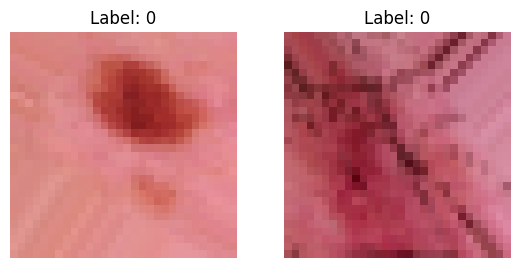

In [565]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()

## model

In [566]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu', use_bias=True))
model.add(Dense(units=32, activation='relu', use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_388 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_340               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_389 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_341               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_390 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_342               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_391 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_343               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_83 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,385 (517.13 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 0 (0.00 B)

In [567]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7385 - loss: 0.5357 - val_accuracy: 0.8400 - val_loss: 0.3808
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8256 - loss: 0.3741 - val_accuracy: 0.8409 - val_loss: 0.3563
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8494 - loss: 0.3325 - val_accuracy: 0.8248 - val_loss: 0.3567
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8635 - loss: 0.3062 - val_accuracy: 0.8419 - val_loss: 0.3435
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8758 - loss: 0.2867 - val_accuracy: 0.8504 - val_loss: 0.3422
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8853 - loss: 0.2639 - val_accuracy: 0.8447 - val_loss: 0.3510
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8911 - loss: 0.2521 - val_accuracy: 0.8277 - val_loss: 0.3615
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8980 - loss: 0.2311 - val_accuracy: 0.

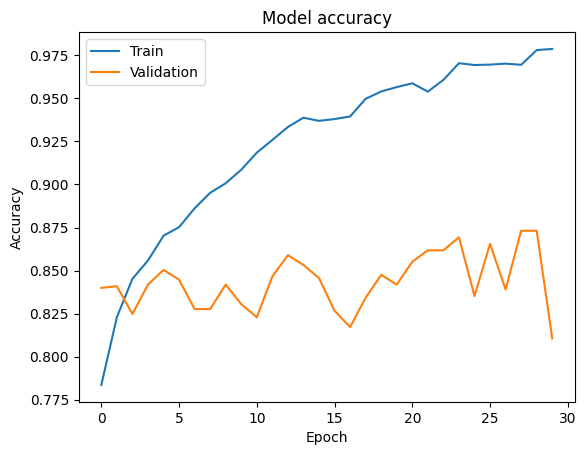

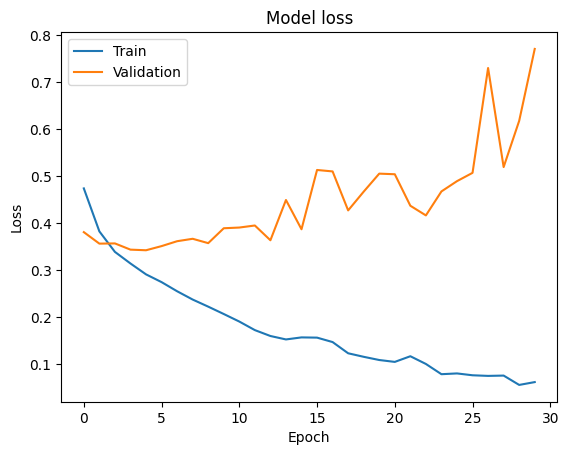

In [568]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


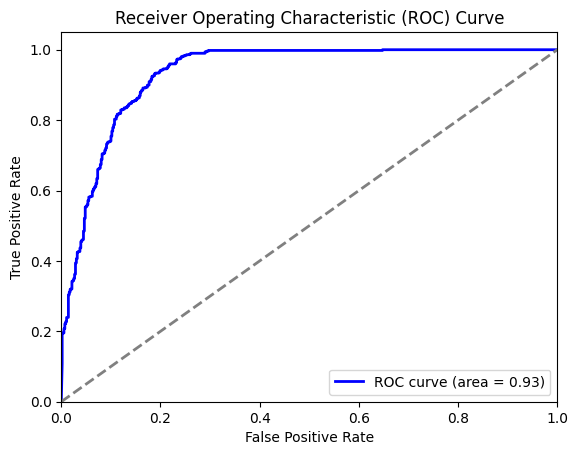

In [569]:
import numpy as np
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([y for x, y in test_ds], axis=0) 
y_pred_proba = model.predict(test_ds).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
roc_auc = auc(fpr, tpr)
plt.figure() 
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")

In [570]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

myModel = Sequential()

myModel.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
myModel.add(Dropout(0.4))

myModel.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
myModel.add(MaxPooling2D(pool_size=(2, 2)))
myModel.add(Dropout(0.2))

myModel.add(Flatten())

myModel.add(Dense(units=32, activation='relu', use_bias=True))
myModel.add(Dense(units=8, activation='relu', use_bias=True))
myModel.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

myModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

myModel.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_392 (Conv2D)             │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_344               │ (None, 14, 14, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_393 (Conv2D)             │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_345               │ (None, 7, 7, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_394 (Conv2D)             │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_346               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_395 (Conv2D)             │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_347               │ (None, 2, 2, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_84 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,009 (269.57 KB)

 Trainable params: 69,009 (269.57 KB)

 Non-trainable params: 0 (0.00 B)

In [571]:
myHistory = myModel.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

test_loss, test_acc = myModel.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6273 - loss: 0.6253 - val_accuracy: 0.8305 - val_loss: 0.4051
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8218 - loss: 0.3938 - val_accuracy: 0.8371 - val_loss: 0.3756
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8250 - loss: 0.3617 - val_accuracy: 0.8400 - val_loss: 0.3514
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8373 - loss: 0.3356 - val_accuracy: 0.8513 - val_loss: 0.3381
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8530 - loss: 0.3149 - val_accuracy: 0.8381 - val_loss: 0.3482
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8584 - loss: 0.3113 - val_accuracy: 0.8504 - val_loss: 0.3361
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8681 - loss: 0.2942 - val_accuracy: 0.8570 - val_loss: 0.3232
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8784 - loss: 0.2788 - val_accuracy: 0.

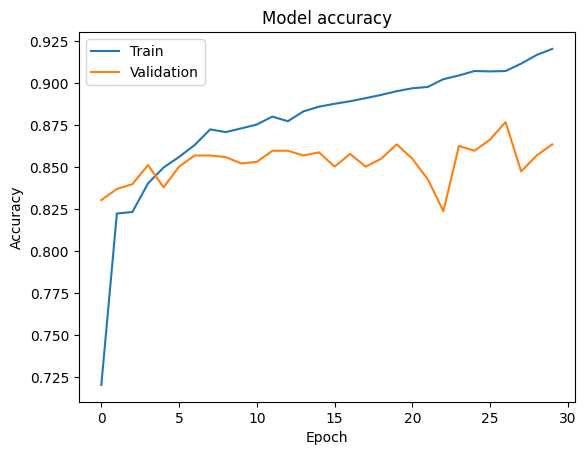

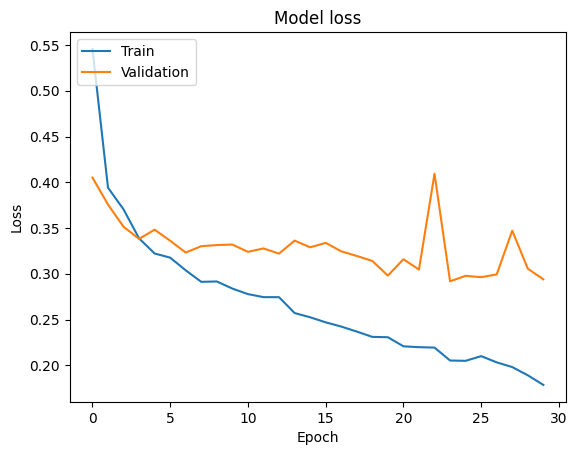

In [572]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(myHistory.history['accuracy'])
plt.plot(myHistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(myHistory.history['loss'])
plt.plot(myHistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


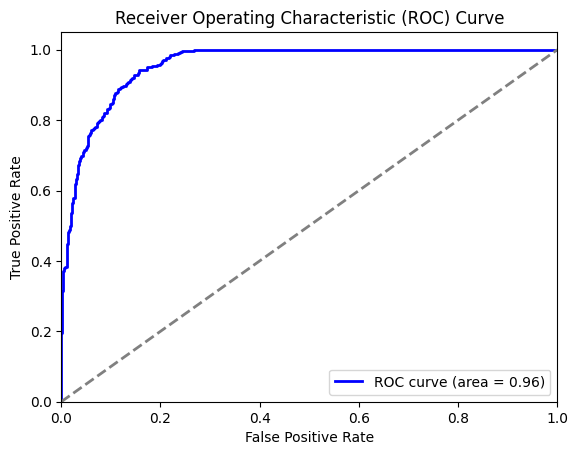

In [573]:
import numpy as np
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([y for x, y in test_ds], axis=0) 
y_pred_proba = myModel.predict(test_ds).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
roc_auc = auc(fpr, tpr)
plt.figure() 
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")

In [574]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

deeperNet = Sequential()

deeperNet.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3), use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
deeperNet.add(Dropout(0.4))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True))
deeperNet.add(MaxPooling2D(pool_size=(2, 2)))
deeperNet.add(Dropout(0.2))

deeperNet.add(Flatten())

deeperNet.add(Dense(units=32, activation='relu', use_bias=True))
deeperNet.add(Dense(units=8, activation='relu', use_bias=True))
deeperNet.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

deeperNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# deeperNet.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [575]:
deeperHistory = deeperNet.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=128)

test_loss, test_acc = deeperNet.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6713 - loss: 0.5860 - val_accuracy: 0.8191 - val_loss: 0.4137
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8193 - loss: 0.4099 - val_accuracy: 0.8040 - val_loss: 0.4311
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8292 - loss: 0.3735 - val_accuracy: 0.7907 - val_loss: 0.4827
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8395 - loss: 0.3492 - val_accuracy: 0.8419 - val_loss: 0.3645
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8479 - loss: 0.3350 - val_accuracy: 0.8428 - val_loss: 0.3617
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8521 - loss: 0.3258 - val_accuracy: 0.8504 - val_loss: 0.3567
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8671 - loss: 0.2990 - val_accuracy: 0.8447 - val_loss: 0.3389
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8632 - loss: 0.2933 - val_accuracy: 0

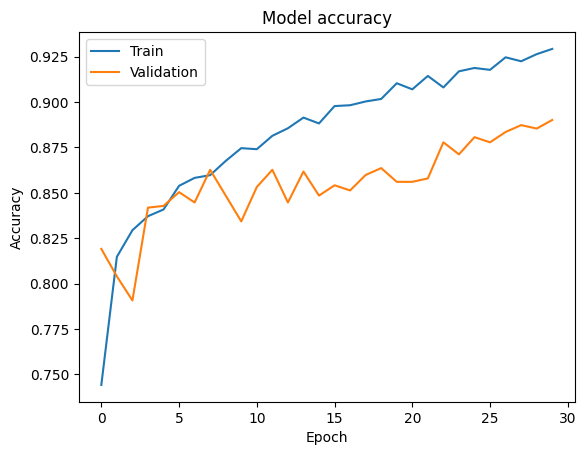

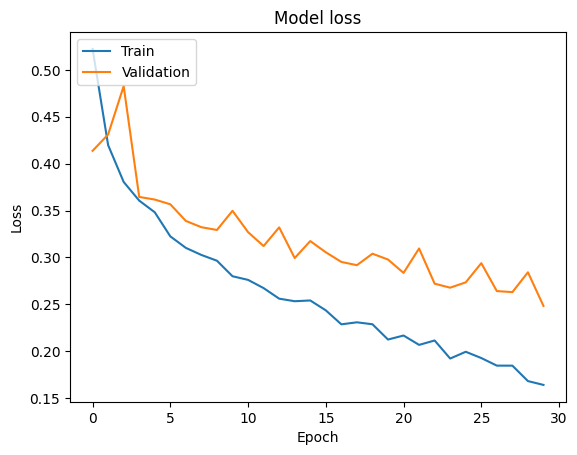

In [576]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(deeperHistory.history['accuracy'])
plt.plot(deeperHistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(deeperHistory.history['loss'])
plt.plot(deeperHistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


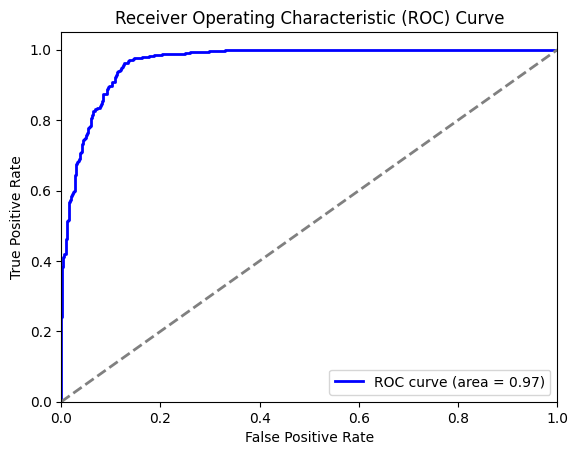

In [577]:
import numpy as np
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([y for x, y in test_ds], axis=0) 
y_pred_proba = deeperNet.predict(test_ds).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba) 
roc_auc = auc(fpr, tpr)
plt.figure() 
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve') 
plt.legend(loc="lower right")